# Reverse engineering ngmix' gaussian moments - part 4

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import ngmix
import autometacal
import tensorflow as tf

Get a galaxy:

In [3]:
scale = .2
stamp_size=51
Ngals = 100
gals, _ = autometacal.data.galaxies.make_data(Ngals=100, img_noise=0.0005,
                                               gal_g1=np.random.uniform(-.1,.1,100),
                                               gal_g2=np.random.uniform(-.1,.1,100),
                                               scale=scale)

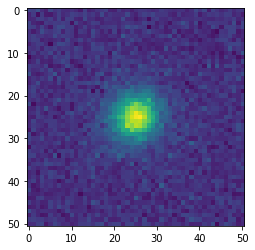

In [4]:
imshow(gals[0].numpy())
obs=ngmix.Observation(gals.numpy()[0],jacobian=ngmix.DiagonalJacobian(row=25, col=25, scale=.2))

Set a fitter with Gaussian moments:

In [10]:
weight_fwhm = scale*stamp_size/2 # <- this sets everything for the window function
fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)
ngmix_results_list = []
for gal in gals:
  obs = ngmix.Observation(gal.numpy(),jacobian=ngmix.DiagonalJacobian(row=25, col=25, scale=.2))
  ngmix_results_list.append(fitter._measure_moments(obs)['e'])

In [13]:
ngmix_results_list

[array([0.03656366, 0.02443017]),
 array([0.04815181, 0.02997293]),
 array([-0.04406886,  0.08280817]),
 array([ 0.04700529, -0.10790162]),
 array([0.00070784, 0.03412434]),
 array([-0.05285146, -0.0680782 ]),
 array([0.09130455, 0.02951935]),
 array([-0.01679221,  0.01659495]),
 array([-0.04438404, -0.02144907]),
 array([ 0.09306163, -0.14146918]),
 array([0.04210909, 0.0756807 ]),
 array([-0.05643344,  0.04180502]),
 array([-0.01534008, -0.07672307]),
 array([0.02377236, 0.00820497]),
 array([ 0.05771182, -0.0423924 ]),
 array([ 0.01978225, -0.04336401]),
 array([ 0.00335184, -0.05047551]),
 array([0.06131557, 0.05297165]),
 array([-0.00337466, -0.02391362]),
 array([ 0.00801941, -0.01223694]),
 array([-0.09009533, -0.07046277]),
 array([ 0.02456844, -0.07570937]),
 array([-0.01973316, -0.00221001]),
 array([-0.06726366,  0.06111391]),
 array([ 0.08412127, -0.08621217]),
 array([ 0.05886854, -0.07570288]),
 array([-0.02714963,  0.0594077 ]),
 array([0.13303385, 0.05892162]),
 array([

In [22]:
pix_weights = tf.ones([Ngals,51,51])
pixels = autometacal.tf_ngmix.make_pixels(gals, pix_weights, [25,25],.2)
T = autometacal.tf_ngmix.fwhm_to_T(weight_fwhm)
weights = autometacal.tf_ngmix.create_gmix([0.,0.,0.,0.,T,1.],'gauss')
our_results =autometacal.tf_ngmix.get_moments(weights,pixels)

In [18]:
our_results.numpy() - np.array(ngmix_results_list)

array([[[-4.37837063e-08, -7.63069475e-09],
        [ 9.19085397e-08,  1.27154992e-09],
        [-2.19621907e-08,  8.61053090e-10],
        [-3.44838241e-08, -2.42480402e-09],
        [-2.93439039e-09,  2.88972386e-09],
        [ 3.52096540e-08, -5.16435063e-09],
        [-5.55975208e-08,  5.62030729e-09],
        [-9.93307274e-09, -1.02740560e-08],
        [ 1.14614930e-08,  8.52259033e-09],
        [ 3.45854042e-08,  1.70166384e-09],
        [-4.13421888e-08, -1.42905948e-09],
        [ 5.12735025e-08,  2.35447749e-09],
        [ 4.04012967e-08,  1.14470788e-08],
        [-5.73226104e-09,  6.46235957e-09],
        [-2.70767369e-08,  6.10461141e-09],
        [-1.15236837e-08,  5.51341874e-09],
        [ 6.64312352e-09,  4.43507463e-09],
        [-4.38290117e-09,  1.45406983e-08],
        [-2.87393939e-08,  5.32181263e-09],
        [-8.13937258e-08,  7.38602437e-09],
        [-4.28215710e-08,  9.23858152e-09],
        [-3.85645930e-08, -8.89763578e-09],
        [-5.79676212e-08, -1.436

## Testing

In [37]:
from numpy.testing import assert_allclose
def test_tf_ngmix():
  """
  This test generates a simple galaxy and measure moments with ngmix, vs.
  tf_ngmix.
  """
  scale = .2
  stamp_size=51
  Ngals = 100

  gals, _ = autometacal.data.galaxies.make_data(Ngals=Ngals, img_noise=0.0005,
                                                 gal_g1=np.random.uniform(-.1,.1,100),
                                                 gal_g2=np.random.uniform(-.1,.1,100),
                                                 scale=scale)

  weight_fwhm = scale*stamp_size/2 # <- this sets everything for the window function
  results_ngmix=[]
  #ngmix version
  
  fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)
  for gal in gals:
    obs = ngmix.Observation(gal.numpy(),jacobian=ngmix.DiagonalJacobian(row=25, col=25, scale=.2))
    results_ngmix.append(fitter._measure_moments(obs)['e'])


  #our version:
  pix_weights = tf.ones([Ngals,51,51])
  pixels = autometacal.tf_ngmix.make_pixels(gals, pix_weights, [25,25],.2)
  T = autometacal.tf_ngmix.fwhm_to_T(weight_fwhm)
  weights = autometacal.tf_ngmix.create_gmix([0.,0.,0.,0.,T,1.],'gauss')
  result_tf_ngmix =autometacal.tf_ngmix.get_moments(weights,pixels)
  
  assert_allclose(results_ngmix,result_tf_ngmix[0],rtol=1e-4)
  
test_tf_ngmix()